# Телеком — задача проекта

## Постановка задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов (client outflow). Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Критерии оценки
Целевой признак: столбец `'EndDate'` равен `'No'`.
Основная метрика: AUC-ROC.
Дополнительная метрика: Accuracy.

Критерии оценки:

- AUC-ROC < 0.75 — 0 sp
- 0.75 ≤ AUC-ROC < 0.81 — 4 sp
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 sp
- 0.85 ≤ AUC-ROC < 0.87 — 5 sp
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 sp
- AUC-ROC ≥ 0.88 — 6 sp

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Чтение и подготовка данных

In [1]:
# подключаем необходимые библиотеки
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report


import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier


In [2]:
#!pip3 install phik

In [3]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [4]:
# для работы в тренажере Яндекс нужно выставить флаг local в False
#local = True
local = False

### contract.csv

In [5]:
# информация о договоре
if local:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col = 'customerID')
else:
    url = "https://drive.google.com/file/d/1ieYIbx_z2Z9I0JcBMGvoTItox5CQF_VY/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    df_contract = pd.read_csv(path, index_col = 'customerID')

In [6]:
df_contract.head(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
df_contract.index.nunique()

7043

In [7]:
df_contract.nunique()

BeginDate             77
EndDate                5
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
dtype: int64

In [8]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


Данные из файла **contract.csv** успешно прочитаны с построением индекса по полю **customerID**. Дублей нет. Пропусков - нет. Поле **MonthlyCharges** из строкового типа, необходимо перевести в тип **float**. Поля **Type, PaperlessBilling, PaymentMethod** перевести в тиg **category**. 

### personal.csv

In [7]:
# персональные данные клиента
if local:
    df_personal = pd.read_csv('personal.csv',index_col = 'customerID')
else:
    url = "https://drive.google.com/file/d/1_zWM79DZi09oZQSDdWk2TDZT_HKz9cnk/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    df_personal = pd.read_csv(path, index_col = 'customerID')

In [8]:
df_personal.head(5)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [10]:
df_personal.nunique()

gender           2
SeniorCitizen    2
Partner          2
Dependents       2
dtype: int64

In [11]:
df_personal.index.nunique()

7043

In [12]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


Данные из файла **personal.csv** успешно прочитаны с построением индекса по полю **customerID**. Дублей нет. Пропусков - нет. Все поля переводим в тип **category**.

### internet.csv

In [9]:
# internet
if local:
    df_internet = pd.read_csv('internet.csv',index_col = 'customerID')
else:
    url = "https://drive.google.com/file/d/1VRZlKCUQJf1JZC9HERgen-9Fp8iRMo20/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    df_internet = pd.read_csv(path, index_col = 'customerID')

In [10]:
df_internet.head(5)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [14]:
df_internet.index.nunique()

5517

In [15]:
df_internet.nunique()

InternetService     2
OnlineSecurity      2
OnlineBackup        2
DeviceProtection    2
TechSupport         2
StreamingTV         2
StreamingMovies     2
dtype: int64

In [16]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


Данные из файла **internet.csv** успешно прочитаны с построением индекса по полю **customerID**. Дублей нет. Пропусков - нет. Все поля переводим в тип **category**.

### phone.csv

In [13]:
# информация об услугах телефонии
if local:
    df_phone = pd.read_csv('phone.csv', index_col = 'customerID')
else:
    url = "https://drive.google.com/file/d/1xvbijCMC5VW1n5ppUUsE1JYZC2sXQ8sK/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    df_phone = pd.read_csv(path, index_col = 'customerID')

In [14]:
df_phone.head(5)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [18]:
df_phone.index.nunique()

6361

In [19]:
df_phone.nunique()

MultipleLines    2
dtype: int64

In [20]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


Данные из файла **phone.csv** успешно прочитаны с построением индекса по полю **customerID**. Дублей нет. Пропусков - нет. Все поля переводим в тип **category**.

### Сборка общего датасета по customerID

In [21]:
df_all = df_contract.join(df_personal).join(df_internet).join(df_phone)

In [22]:
df_all.isna().any()

BeginDate           False
EndDate             False
Type                False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
InternetService      True
OnlineSecurity       True
OnlineBackup         True
DeviceProtection     True
TechSupport          True
StreamingTV          True
StreamingMovies      True
MultipleLines        True
dtype: bool

Заполним пропуски по клиентам у которых отсутствуют подключенные услуги строковым значением 'No data'. Считаем как отдельную категорию.

In [23]:
df_all = df_all.fillna('No data')

In [24]:
df_all.head(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No data
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No data
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [25]:
df_all.columns = df_all.columns.str.lower()

In [26]:
df_all.columns

Index(['begindate', 'enddate', 'type', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'gender', 'seniorcitizen', 'partner',
       'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
       'multiplelines'],
      dtype='object')

In [27]:
df_all.columns = ['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'gender', 'senior_citizen', 'partner',
       'dependents', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines']

In [28]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   object 
 13  online_backup      7043 non-null   object 
 14  device_protection  7043 non-null   object 
 15  tech_support       7043 non-null   object 
 16  streaming_tv  

Пропусков нет. Теперь преобразуем типы данных.

### Преобразование типов данных

In [29]:
# TotalCharges 
df_all['total_charges'] = df_all['total_charges'].replace(' ','0.0')
df_all['total_charges'] = df_all['total_charges'].astype('float64')

# SeniorCitizen
df_all['senior_citizen'] = df_all['senior_citizen'].astype('category')

In [30]:
# строковые типы переводим в категориальные
list_object_columns = list(df_all.dtypes[df_all.dtypes == object].index)

for col in list_object_columns:
    if col == 'end_date' or col =='begin_date':
        continue  
    df_all[col] = df_all[col].astype('category') 

In [31]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   begin_date         7043 non-null   object  
 1   end_date           7043 non-null   object  
 2   type               7043 non-null   category
 3   paperless_billing  7043 non-null   category
 4   payment_method     7043 non-null   category
 5   monthly_charges    7043 non-null   float64 
 6   total_charges      7043 non-null   float64 
 7   gender             7043 non-null   category
 8   senior_citizen     7043 non-null   category
 9   partner            7043 non-null   category
 10  dependents         7043 non-null   category
 11  internet_service   7043 non-null   category
 12  online_security    7043 non-null   category
 13  online_backup      7043 non-null   category
 14  device_protection  7043 non-null   category
 15  tech_support       7043 non-null   category
 

### Конструирование новых признаков

Нам известно, что данные актуальны на 1 Февраля 2020. Добавим вспомогательную колонку "Дата актуальности". Для уже закрытых договоров дату актуальности сместим на дату закрытия договора. Данная колонка поможет нам рассчитать срок лояльности клиента **tenure_days**, как разность между датой актуальности и датой начала договора.

In [32]:
df_all['begin_date'] = pd.to_datetime(df_all['begin_date'], format='%Y-%m-%d')
def new_features(raw):
    raw['date_of_relevance'] = raw['end_date'].apply(lambda x: '2020-02-01 00:00:00' if x =='No' else x)
    raw['date_of_relevance'] = pd.to_datetime(raw['date_of_relevance'], format='%Y-%m-%d %S:%M:%H')
    raw['tenure_days'] = (raw['date_of_relevance'] - raw['begin_date']).astype('timedelta64[D]')
    raw['tenure_days'] = raw['tenure_days'].astype('int64')
    return raw 

df_all = (df_all.pipe(new_features))

In [33]:
df_all.head(5)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,date_of_relevance,tenure_days
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,No data,2020-02-01,31
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,2020-02-01,1036
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,2019-12-01,61
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,...,DSL,Yes,No,Yes,Yes,No,No,No data,2020-02-01,1371
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,...,Fiber optic,No,No,No,No,No,No,No,2019-11-01,61


### Построение целевого признака

**За отток клиента будем считать заполненную дату окончания договора.**

In [34]:
# Добавим колонку с целевым признаком
df_all['exited'] = df_all['end_date'].apply(lambda x: int(x!='No'))
df_all['exited'] = df_all['exited'].astype('int')

In [35]:
df_all.head(5)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,date_of_relevance,tenure_days,exited
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,...,No,Yes,No,No,No,No,No data,2020-02-01,31,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,...,Yes,No,Yes,No,No,No,No,2020-02-01,1036,0
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,...,Yes,Yes,No,No,No,No,No,2019-12-01,61,1
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,...,Yes,No,Yes,Yes,No,No,No data,2020-02-01,1371,0
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,...,No,No,No,No,No,No,No,2019-11-01,61,1


Удаляем ненужные колонки с датами

In [36]:
if 'begin_date' in df_all.columns:
    del df_all['begin_date']
if 'end_date' in df_all.columns:
    del df_all['end_date'] 
if 'date_of_relevance' in df_all.columns:
    del df_all['date_of_relevance']        

In [37]:
# Переиндексируемся и уберем customerID из колонок.
df_all = df_all.reset_index(drop=True)
if 'customerID' in df_all.columns:
     df_all = df_all.drop(['customerID'], axis=1)

In [38]:
# проверим дубли
df_all = df_all.drop_duplicates()
sum(df_all.duplicated())

0

In [39]:
df_all.head(5)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,tenure_days,exited
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No data,31,0
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,1
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No data,1371,0
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,1


In [40]:
#df_all.to_csv('final.csv', index=False)

**Вывод: Подготовлен итоговый датасет для исследования задачи.**

## Исследование задачи (EDA)

### Рассмотрим датасет на наличие дисбаланса классов.

''

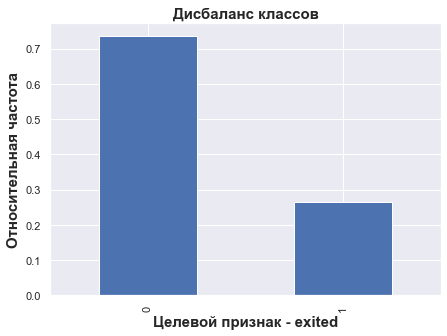

In [41]:
sns.set(rc={'figure.figsize':(7, 5)})
class_frequency = df_all['exited'].value_counts(normalize=True)
class_frequency.plot(kind='bar')
plt.xlabel('Целевой признак - exited',fontsize=15, weight = 'bold')
plt.ylabel('Относительная частота',fontsize=15, weight = 'bold')
plt.title("Дисбаланс классов",fontsize=15, weight = 'bold')
;

In [42]:
print(class_frequency)

0    0.735089
1    0.264911
Name: exited, dtype: float64


In [43]:
0.73463/0.26537

2.768323472886913

 **Вывод: Мы имеем выраженный дисбаланс классов в отношении 0 класса к 1 классу, как 3:1.**

### Попробуем предварительно выявить наиболее значимые признаки, которые влияют на отток клиетов

<!-- Воспользуемся OrdinalEncoder для преобразования категориальных значений в числовые и построим матрицу корреляции признаков. -->

### Линейные зависимости

Попробуем выявить линейные зависимости между числовыми данными.

In [44]:
df_float = df_all[['tenure_days','monthly_charges','total_charges','exited']]

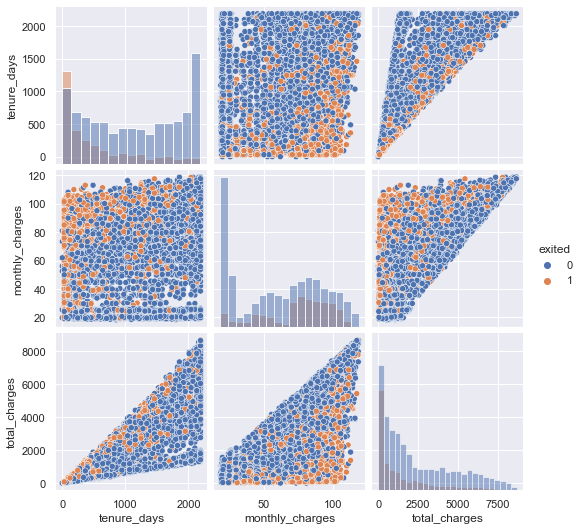

In [45]:
sns.pairplot(df_float, hue='exited', diag_kind='hist')
plt.show()

#### Проверка на мультиколлинеарность признаков

Для числовых переменных можно построить матрицу корреляции Пирсона.

In [46]:
df_float[['monthly_charges','total_charges', 'tenure_days']].corr()

,monthly_charges,total_charges,tenure_days
monthly_charges,1.000000,0.650703,0.245416
total_charges,0.650703,1.000000,0.825631
tenure_days,0.245416,0.825631,1.000000


**Зависимость между total_charges и tenure_days - значительна 0.65 и может негативно сказаться на моделях. Перед обучением модели нужно будет удалить потенциально опасный признак**

### Нелинейный зависимости

Нелинейные зависимости попробуем выявить через Phik (𝜙k)

https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7

Данный критерий работает с любыми типами переменных. 

Цитирую документацию:

**Phi_K is a new and practical correlation coefficient based on several refinements to Pearson’s hypothesis test of independence of two variables.**

**The combined features of Phi_K form an advantage over existing coefficients. First, it works consistently between categorical, ordinal and interval variables. Second, it captures non-linear dependency. Third, it reverts to the Pearson correlation coefficient in case of a bi-variate normal input distribution. These are useful features when studying the correlation matrix of variables with mixed types.**

**.........**

**The calculation of correlation coefficients between paired data variables is a standard tool of analysis for every data analyst. Pearson’s correlation coefficient is a de facto standard in most fields, but by construction only works for interval variables (sometimes called continuous variables). Pearson is unsuitable for data sets with mixed variable types, e.g. where some variables are ordinal or categorical.**


Приступим к анализу...

Строим матрицу по всем типам переменных, включая категориальные.

In [47]:
phik_overview = df_all.phik_matrix()
phik_overview.round(2)
phik_overview['exited'].sort_values(ascending=False).to_frame().style.background_gradient()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'tenure_days', 'exited']


,exited
exited,1.000000
tenure_days,0.474244
payment_method,0.448478
monthly_charges,0.359682
paperless_billing,0.293762
total_charges,0.277906
dependents,0.253492
type,0.251794
senior_citizen,0.233709
partner,0.232083


In [48]:
# взаимное влияние total_charges, monthly_charges и tenure_days
phik_overview = df_all[['monthly_charges','total_charges','tenure_days','exited']].phik_matrix()
phik_overview.round(2)
#phik_overview['Exited'].sort_values(ascending=False).to_frame()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'tenure_days', 'exited']


,monthly_charges,total_charges,tenure_days,exited
monthly_charges,1.00,0.76,0.41,0.36
total_charges,0.76,1.00,0.84,0.28
tenure_days,0.41,0.84,1.00,0.47
exited,0.36,0.28,0.47,1.00


По прежнему мы видим сильное взаимное влияние total_charges и tenure_days.

**Вывод по выявленным нелинейным зависимостям:**

- При изучении нелинейных связей, на первые места, как и ожидалось, вышли деньги. **monthly_charges**

- Наиболее значимые признаки это: **tenure_days, payment_method, monthly_charges, paperless_billing**.

- То есть, размер ежемесячных платежей **monthly_charges** - имеет значение. А также способ платежа payment_method и электронный чек paperless_billing.

- Наличие иждивенцев dependents, пенсионный возраст senior_citizen, состоит ли в браке partner также важно.

- Телефония multiple_lines, пол gender, streaming_tv и streaming_movies  -  не играют значительной роли.

**P.S. Данные выводы являются предварительными, так как критерий Phik (𝜙k) - не является общепринятым, в отличии от критерия Пирсона. Окончательные выводы, мы сделаем в ходе, попарного сравнения количественного показателя (отток) и значениями категориальных признаков. Ниже по тексту.....**

### Посмотрим на наиболее значимые признаки и их значения влияющие на отток

#### tenure_days (длительность клиентских отношений)

Text(0, 0.5, 'Количество')

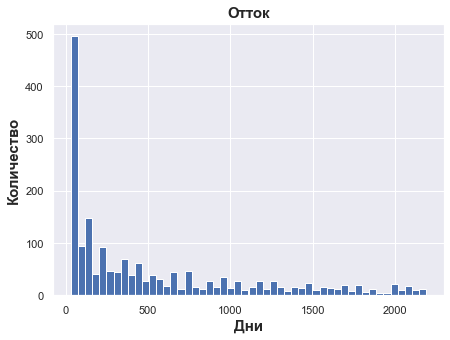

In [49]:
df_all[df_all['exited']==1]['tenure_days'].hist(bins=50)
plt.title("Отток",fontsize=15, weight = 'bold');
plt.xlabel('Дни', fontsize=15, weight = 'bold')
plt.ylabel('Количество', fontsize=15, weight = 'bold')

Text(0, 0.5, 'Количество')

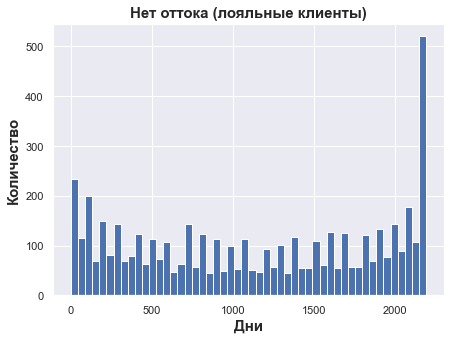

In [50]:
df_all[df_all['exited']==0]['tenure_days'].hist(bins=50)
plt.title("Нет оттока (лояльные клиенты)",fontsize=15, weight = 'bold');
plt.xlabel('Дни', fontsize=15, weight = 'bold')
plt.ylabel('Количество', fontsize=15, weight = 'bold')

Наибольший отток происходит в первый год. При дальнейших отношениях отток снижается.

#### Type (Вид договора)

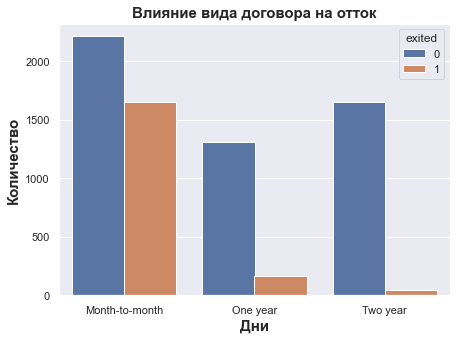

In [51]:
sns.set(rc={'figure.figsize':(7, 5)})
sns.countplot(x=df_all['type'], hue=df_all['exited'])
plt.xlabel('Дни', fontsize=15, weight = 'bold')
plt.ylabel('Количество', fontsize=15, weight = 'bold')
plt.title("Влияние вида договора на отток",fontsize=15, weight = 'bold');

Вывод: Отток максимален для помесячных договоров.

#### Подключение сервисов 'online_security', 'online_backup', 'device_protection', 'tech_support'

In [52]:
def plot_hist_groups(data, cols, n_cols):

    fig, ax = plt.subplots(nrows=1, ncols=n_cols, figsize = (15,4))
    for i, col in enumerate(cols):

        ax[i].hist(data[data['exited'] == 0][col], ec='black', alpha=0.42)
        ax[i].hist(data[data['exited'] == 1][col], ec='black', alpha=0.84)
        ax[i].set_title(f"Подключение сервиса {col}")
        ax[i].legend(['Нет оттока', 'Отток'])

    plt.ylabel('Количество человек')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

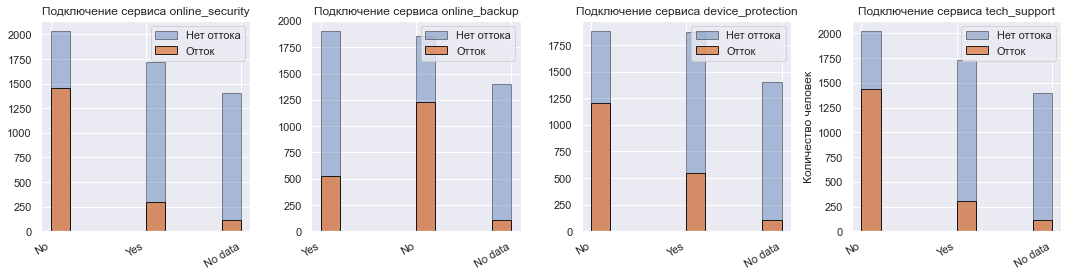

In [53]:
cols = ['online_security', 'online_backup', 'device_protection', 'tech_support']
plot_hist_groups(df_all, cols, 4)

#### Способ оплаты payment_method

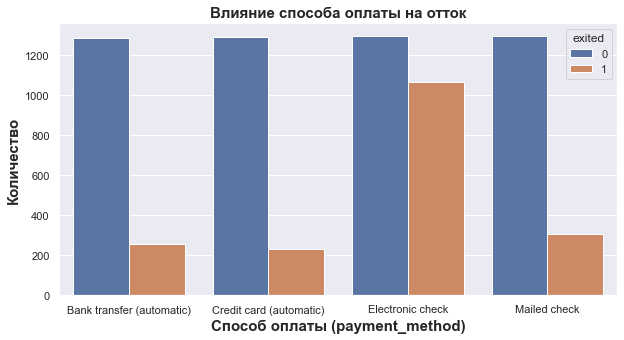

In [54]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.countplot(x=df_all['payment_method'], hue=df_all['exited'])
plt.xlabel('Способ оплаты (payment_method)', fontsize=15, weight = 'bold')
plt.ylabel('Количество', fontsize=15, weight = 'bold')
plt.title("Влияние способа оплаты на отток",fontsize=15, weight = 'bold');


Способ платежа Electronic check, крайне не популярен и способствует оттоку.

#### Наличие иждивенцев dependents

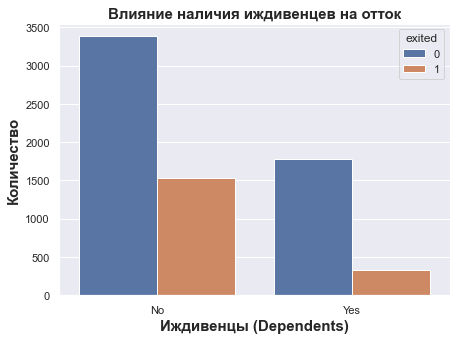

In [55]:
sns.set(rc={'figure.figsize':(7, 5)})
sns.countplot(x=df_all['dependents'], hue=df_all['exited'])
plt.xlabel('Иждивенцы (Dependents)', fontsize=15, weight = 'bold')
plt.ylabel('Количество', fontsize=15, weight = 'bold')
plt.title("Влияние наличия иждивенцев на отток",fontsize=15, weight = 'bold');

Наличие иждивенцев, как это не странно, снижает отток.

#### Пенсионер senior_citizen

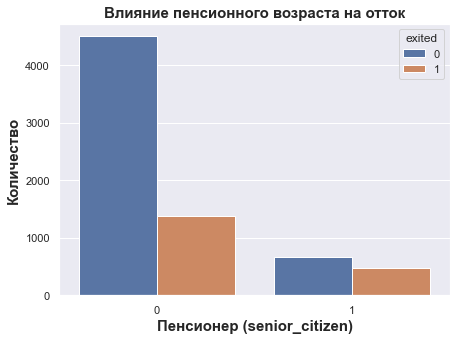

In [56]:
sns.set(rc={'figure.figsize':(7, 5)})
sns.countplot(x=df_all['senior_citizen'], hue=df_all['exited'])
plt.xlabel('Пенсионер (senior_citizen)', fontsize=15, weight = 'bold')
plt.ylabel('Количество', fontsize=15, weight = 'bold')
plt.title("Влияние пенсионного возраста на отток",fontsize=15, weight = 'bold');

Пенсионеры не склонны к переменам.

#### Брак partner

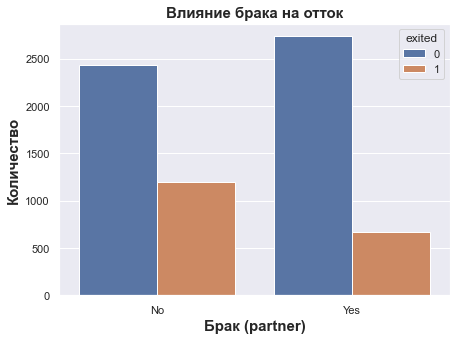

In [57]:
sns.set(rc={'figure.figsize':(7, 5)})
sns.countplot(x=df_all['partner'], hue=df_all['exited'])
plt.xlabel('Брак (partner)', fontsize=15, weight = 'bold')
plt.ylabel('Количество', fontsize=15, weight = 'bold')
plt.title("Влияние брака на отток",fontsize=15, weight = 'bold');

Отсутствие брака способствует оттоку.

### Посмотрим на наимение значимые признаки влияющие на отток

Возьмем для примера два признака gender и MultipleLines. Этого будет достаточно для понимания.

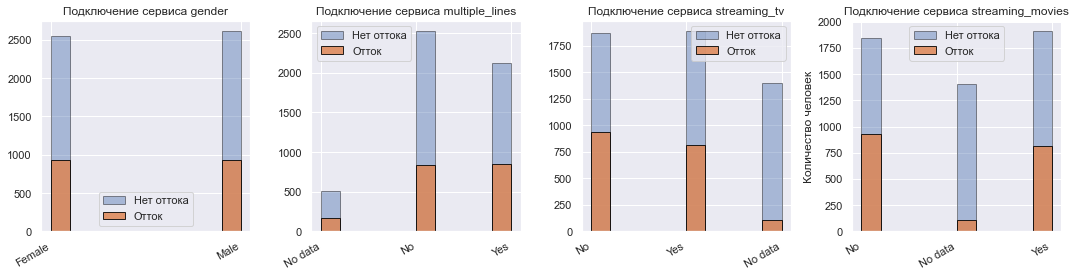

In [58]:
cols = ['gender', 'multiple_lines', 'streaming_tv', 'streaming_movies']
plot_hist_groups(df_all, cols, 4)

Мы видим равный отток для gender, и сервисов 'multiple_lines', 'streaming_tv', 'streaming_movies'.

**Итоги EDA**
- Наибольший отток происходит в первый год. При дальнейших отношениях отток незначителен. Видимо это связано с процедурой перезаключения договоров. Чем больше длительность отношений, тем меньше отток.

- Сумма платежа **monthly_charges** обратно пропорциональна оттоку. Способ платежа  **payment_method** - важен, так как Electronic check, крайне не популярен и способствует оттоку.
- Наличие иждивенцев dependents, пенсионный возраст senior_citizen, состоит ли клиент в браке partner также важно. Иждивенци уменьшают отток, пенсионеры к нему не склонны, холостые склонны к оттоку и переменам.  
- Отток больше для клиентов заключивших договор на месяц. При годовых договорах и более оток меньше.
- При не подключенных сервисах **online_security, online_backup, device_protection, tech_support** отток будет увеличиться.
- Телефония **multiple_lines**, сервисы **streaming_tv, streaming_movies** не влияют на отток 
- пол **gender** минимально влияют на отток.

## Построение моделей

Доработаем датасет. Уберем возможно опасный признак.

In [59]:
df = df_all.copy()
if 'total_charges' in df.columns:
    del df['total_charges']

Подготовим категориальные данные по технологии **OHE**.

In [60]:
df_ohe = pd.get_dummies(df, drop_first=True )

In [61]:
df_ohe.head(2)

,monthly_charges,tenure_days,exited,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,...,device_protection_No data,device_protection_Yes,tech_support_No data,tech_support_Yes,streaming_tv_No data,streaming_tv_Yes,streaming_movies_No data,streaming_movies_Yes,multiple_lines_No data,multiple_lines_Yes
0,29.85,31,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,56.95,1036,0,1,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0


In [62]:
X = df_ohe.drop('exited', axis=1)
y = df_ohe['exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [106]:
# собирать данные о моделях будем в список
result_list = []

### Baseline (DummyClassifier)

Для проверки адекватности дальнейших моделей возьмем в качестве baseline модель DummyClassifier со стратифицированной выборкой для учета дисбаланса классов.

In [64]:
model = DummyClassifier(strategy='stratified')
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]

In [65]:
#метрики
auc = roc_auc_score(y_test, y_pred)
y_bin = (y_pred >= 0.5)*1
acc = accuracy_score(y_test, y_bin, normalize=True)
pre = precision_score(y_test, y_bin)
rec = recall_score(y_test, y_bin)

print("DummyClassifier")
print("")
print('roc_auc_score:',auc)
print("accuracy_score:",acc)
print("")
print(classification_report(y_test, y_bin))

DummyClassifier

roc_auc_score: 0.5024011960180712
accuracy_score: 0.6112692088787707

              precision    recall  f1-score   support

           0       0.73      0.74      0.74      1279
           1       0.28      0.26      0.27       478

    accuracy                           0.61      1757
   macro avg       0.50      0.50      0.50      1757
weighted avg       0.61      0.61      0.61      1757



In [66]:
def draw_roc_curve(y_test, y_pred, model=''):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая ' + model)

    plt.show()    

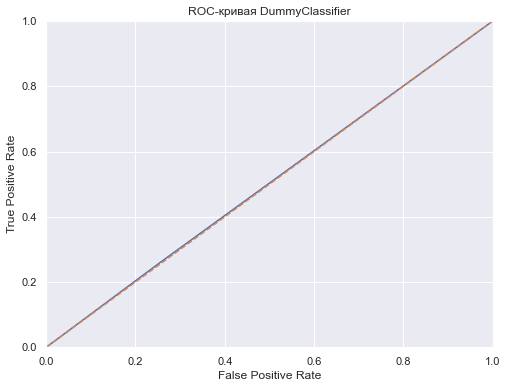

In [67]:
draw_roc_curve(y_test, y_pred, model='DummyClassifier')

In [107]:
# добавляем данные по модели
result_list.append({ 'Model':'DummyClassifier','roc_auc_score':auc,'accuracy_score':acc, 'precision':pre,'recall':rec}) 
result_list    

[{'Model': 'DummyClassifier',
  'roc_auc_score': 0.9063836155992686,
  'accuracy_score': 0.8264086511098463,
  'precision': 0.6473594548551959,
  'recall': 0.7949790794979079}]

### LogisticRegression

В качестве точки старта будем использовать логистическую регрессию **LogisticRegression**.

In [69]:
# инициализируем модель LogisticRegression 
lr_model = LogisticRegression(solver='liblinear', random_state=42, class_weight = 'balanced') 
   
# обучим модель на тренировочной выборке
lr_model.fit(X_train, y_train)
    
# получим предсказания модели на валидационной выборке
#y_pred = lr_model.predict(X_test)
y_pred = lr_model.predict_proba(X_test)[:, 1]

In [70]:
#метрики
auc = roc_auc_score(y_test, y_pred)
y_bin = (y_pred >= 0.5)*1
acc = accuracy_score(y_test, y_bin, normalize=True)
pre = precision_score(y_test, y_bin)
rec = recall_score(y_test, y_bin)

print("LogisticRegression")
print("")
print('roc_auc_score:',auc)
print("accuracy_score:",acc)
print("")
print(classification_report(y_test, y_bin))

LogisticRegression

roc_auc_score: 0.8321305544014839
accuracy_score: 0.7398975526465567

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1279
           1       0.51      0.79      0.62       478

    accuracy                           0.74      1757
   macro avg       0.71      0.75      0.71      1757
weighted avg       0.80      0.74      0.75      1757



#### Кривая ROC AUC LogisticRegression  

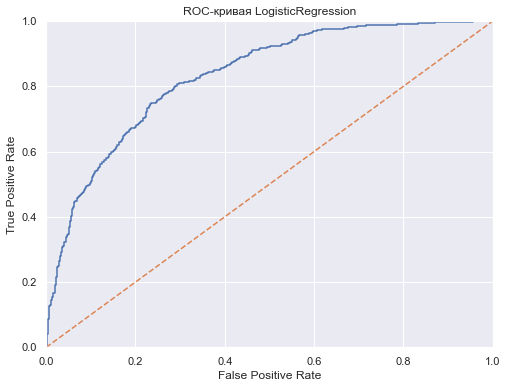

In [71]:
draw_roc_curve(y_test, y_pred, model='LogisticRegression')

In [108]:
# добавляем данные по модели
result_list.append({ 'Model':'LogisticRegression','roc_auc_score':auc,'accuracy_score':acc, 'precision':pre,'recall':rec}) 

### RandomForestClassifier

In [73]:
rfc_model = RandomForestClassifier(random_state=42, class_weight = 'balanced')

In [74]:
%%time
rfc_param_list = {"max_depth": [4, 8, 10, 50],
                 "n_estimators": [200, 500, 1000],
                  "criterion": ['gini', 'entropy'],                 
}                        

my_cv = StratifiedKFold(n_splits=5).split(X_train, y_train)              
            
grid_search = GridSearchCV(rfc_model, n_jobs = -1, param_grid = rfc_param_list, cv = my_cv, \
                           scoring = "roc_auc", verbose = 5)

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Wall time: 2min 19s


GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000013FAD6E5740>,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 10, 50],
                         'n_estimators': [200, 500, 1000]},
             scoring='roc_auc', verbose=5)

In [75]:
best_params_rfc = grid_search.best_params_
best_params_rfc

{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 1000}

In [76]:
# grid_search.best_score_

In [77]:
rfc_model = RandomForestClassifier(**best_params_rfc, class_weight = 'balanced', random_state=42) 

rfc_model.fit(X_train, y_train)
#y_pred = rfc_model.predict(X_test)
y_pred = rfc_model.predict_proba(X_test)[:, 1]

In [78]:
#метрики
auc = roc_auc_score(y_test, y_pred)
y_bin = (y_pred >= 0.5)*1
acc = accuracy_score(y_test, y_bin, normalize=True)
pre = precision_score(y_test, y_bin)
rec = recall_score(y_test, y_bin)

print("RandomForestClassifier ")
print("")
print('roc_auc_score:',auc)
print("accuracy_score:",acc)
print("")
print(classification_report(y_test, y_bin))

RandomForestClassifier 

roc_auc_score: 0.8474807070115578
accuracy_score: 0.7478656801365965

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1279
           1       0.53      0.77      0.62       478

    accuracy                           0.75      1757
   macro avg       0.71      0.75      0.72      1757
weighted avg       0.79      0.75      0.76      1757



#### Кривая ROC AUC RandomForestClassifier   

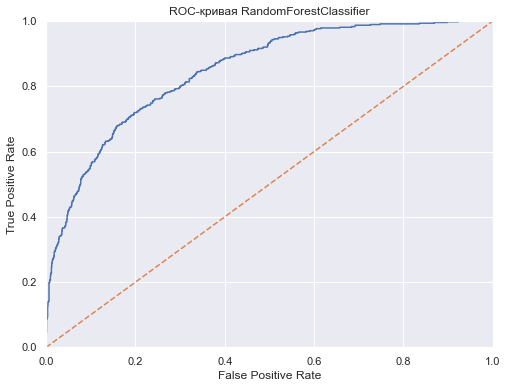

In [79]:
draw_roc_curve(y_test, y_pred, 'RandomForestClassifier')

In [109]:
# добавляем данные по модели
result_list.append({ 'Model':'RandomForestClassifier','roc_auc_score':auc,'accuracy_score':acc,\
                    'precision':pre,'recall':rec}) 

### CatBoostClassifier

CatBoostClassifier не требует технологии OHE для работы с категориальными данными. Поэтому заново подготовим разбиение данных.

In [81]:
X = df.drop(['exited'], axis=1)
y = df['exited'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Подготовим список категориальных колонок.

In [82]:
category_cols = list(df.dtypes[df.dtypes == 'category'].index)
cat_features_names = [col for col in X.columns if col in (category_cols)]
cat_features = [X.columns.get_loc(col) for col in cat_features_names]
print(cat_features_names)

['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


Балансировка классов

In [83]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.677992277992278, 1: 1.9045553145336225}

In [84]:
%%time
cb_model = CatBoostClassifier(class_weights=class_weights, cat_features=cat_features, random_seed=42, iterations=100)

grid = {'learning_rate': [0.01, 0.1],
        'depth': [2, 4, 6],
        'n_estimators': [100, 200, 500],
        'l2_leaf_reg': [1,2]}

grid_search_result = cb_model.grid_search(grid, X=X_train, y=y_train, plot=False, cv = 3, stratified = True)

0:	learn: 0.6896919	test: 0.6896985	best: 0.6896985 (0)	total: 179ms	remaining: 17.7s
1:	learn: 0.6864624	test: 0.6865040	best: 0.6865040 (1)	total: 201ms	remaining: 9.86s
2:	learn: 0.6835908	test: 0.6835642	best: 0.6835642 (2)	total: 214ms	remaining: 6.92s
3:	learn: 0.6803709	test: 0.6803635	best: 0.6803635 (3)	total: 226ms	remaining: 5.42s
4:	learn: 0.6773367	test: 0.6773041	best: 0.6773041 (4)	total: 236ms	remaining: 4.49s
5:	learn: 0.6747601	test: 0.6747645	best: 0.6747645 (5)	total: 247ms	remaining: 3.87s
6:	learn: 0.6721847	test: 0.6720723	best: 0.6720723 (6)	total: 259ms	remaining: 3.44s
7:	learn: 0.6696445	test: 0.6696502	best: 0.6696502 (7)	total: 270ms	remaining: 3.1s
8:	learn: 0.6668589	test: 0.6668016	best: 0.6668016 (8)	total: 280ms	remaining: 2.83s
9:	learn: 0.6644324	test: 0.6643847	best: 0.6643847 (9)	total: 288ms	remaining: 2.6s
10:	learn: 0.6623001	test: 0.6622809	best: 0.6622809 (10)	total: 297ms	remaining: 2.41s
11:	learn: 0.6597641	test: 0.6597260	best: 0.6597260 (

In [85]:
best_params_cb = grid_search_result['params'] 

In [86]:
best_params_cb

{'depth': 4, 'l2_leaf_reg': 1, 'iterations': 500, 'learning_rate': 0.1}

In [87]:
cb_model = CatBoostClassifier(class_weights=class_weights, cat_features=cat_features, \
                              random_seed=42, **best_params_cb, silent= True)

In [88]:
cb_model.fit(X_train, y_train)
#y_pred = cb_model.predict(X_test)
y_pred = cb_model.predict_proba(X_test)[:, 1]

In [89]:
#метрики
auc = roc_auc_score(y_test, y_pred)
y_bin = (y_pred >= 0.5)*1
acc = accuracy_score(y_test, y_bin, normalize=True)
pre = precision_score(y_test, y_bin)
rec = recall_score(y_test, y_bin)

print("CatBoostClassifier  ")
print("")
print('roc_auc_score:',auc)
print("accuracy_score:",acc)
print("")
print(classification_report(y_test, y_bin))

CatBoostClassifier  

roc_auc_score: 0.9156408150980925
accuracy_score: 0.8315310187820149

              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1279
           1       0.65      0.83      0.73       478

    accuracy                           0.83      1757
   macro avg       0.79      0.83      0.80      1757
weighted avg       0.85      0.83      0.84      1757



#### Кривая ROC AUC CatBoostClassifier    

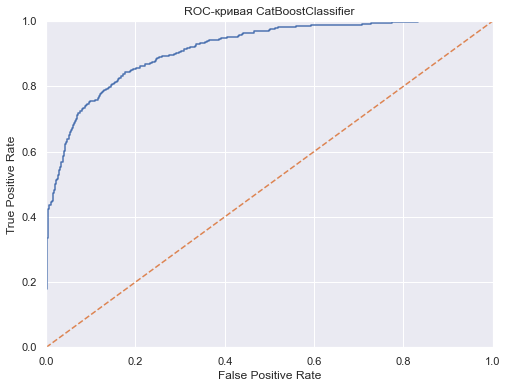

In [90]:
draw_roc_curve(y_test, y_pred, 'CatBoostClassifier')

#### Важность признаков

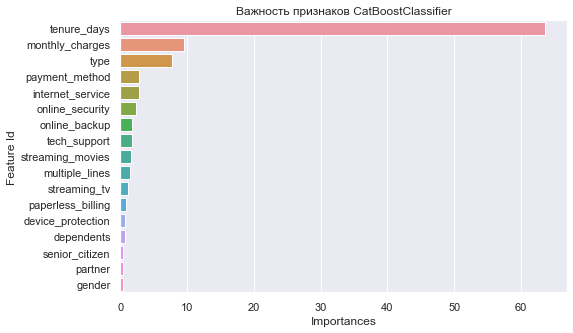

In [91]:
fi = cb_model.get_feature_importance(prettified=True)

plt.figure(figsize=(8, 5));
sns.barplot(x="Importances", y="Feature Id", data=fi);
plt.title('Важность признаков CatBoostClassifier');

Важность признаков tenure_days, monthly_charges и type и payment_method совпадает с оценками полученными в EDA.

In [110]:
# добавляем данные по модели
result_list.append({ 'Model':'CatBoostClassifier  ','roc_auc_score':auc,'accuracy_score':acc, \
                    'precision':pre,'recall':rec}) 

### LGBMClassifier

LGBMClassifier не требует технологии OHE для работы с категориальными данными. Поэтому заново подготовим разбиение данных.

In [93]:
X = df.drop(['exited'], axis=1)
y = df['exited'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [94]:
%%time
lg = lgb.LGBMClassifier(silent=True, class_weight = 'balanced')

param_list = {"max_depth": [10, 50, 100],
               "num_leaves":[20, 30],
               "learning_rate" : [0.1,0.5],
               "boosting_type": ['gbdt'], #,'goss','rf'],
               "n_estimators": [100, 200]
}                        

my_cv = StratifiedKFold(n_splits=5).split(X_train, y_train)              
            
grid_search = GridSearchCV(lg, n_jobs = -1, param_grid = param_list, cv = my_cv, \
                           scoring = "roc_auc", verbose = 5)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Wall time: 13 s


GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000013FAD703510>,
             estimator=LGBMClassifier(class_weight='balanced'), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'], 'learning_rate': [0.1, 0.5],
                         'max_depth': [10, 50, 100], 'n_estimators': [100, 200],
                         'num_leaves': [20, 30]},
             scoring='roc_auc', verbose=5)

In [95]:
best_params_lgb = grid_search.best_params_

In [96]:
best_params_lgb

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 200,
 'num_leaves': 20}

In [97]:
lgb_model = lgb.LGBMClassifier(**best_params_lgb, silent=True, class_weight = 'balanced', random_state=42)

In [98]:
lgb_model.fit(X_train, y_train)
#y_pred = lgb_model.predict(X_test) 
y_pred = lgb_model.predict_proba(X_test)[:, 1]

In [99]:
#метрики
auc = roc_auc_score(y_test, y_pred)
y_bin = (y_pred >= 0.5)*1
acc = accuracy_score(y_test, y_bin, normalize=True)
pre = precision_score(y_test, y_bin)
rec = recall_score(y_test, y_bin)

print("LGBMClassifier")
print("")
print('roc_auc_score:',auc)
print("accuracy_score:",acc)
print("")
print(classification_report(y_test, y_bin))

LGBMClassifier

roc_auc_score: 0.9063836155992686
accuracy_score: 0.8264086511098463

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1279
           1       0.65      0.79      0.71       478

    accuracy                           0.83      1757
   macro avg       0.78      0.82      0.79      1757
weighted avg       0.84      0.83      0.83      1757



#### Кривая ROC AUC LGBMClassifier    

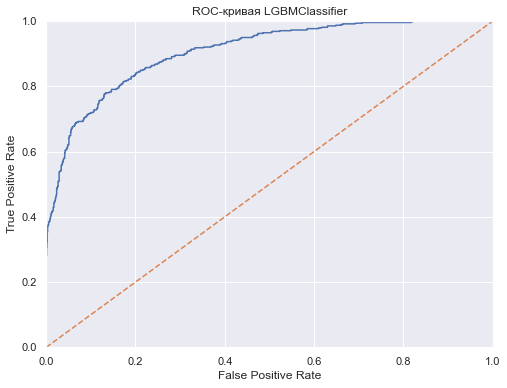

In [100]:
draw_roc_curve(y_test, y_pred, 'LGBMClassifier')

#### Важность признаков LGBMClassifier

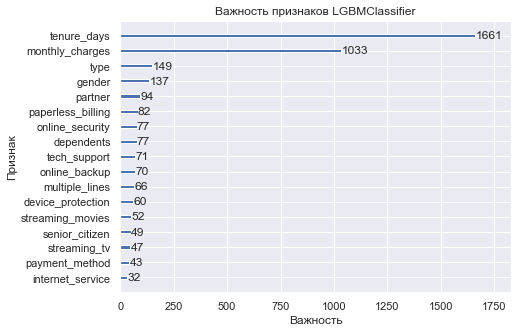

In [101]:
ax0 = lgb.plot_importance(lgb_model, color='b', title='Важность признаков LGBMClassifier', xlabel='Важность', \
                          ylabel='Признак', figsize=(7,5))

In [111]:
# добавляем данные по модели
result_list.append({ 'Model':'LGBMClassifier','roc_auc_score':auc,'accuracy_score':acc, 'precision':pre,'recall':rec}) 

Важность признаков tenure_days, monthly_charges и type совпадает с оценками полученными в EDA.

In [112]:
# соберем итоговую табличку
result = pd.DataFrame(result_list)
result = result.sort_values(by=['roc_auc_score'])
;

''

## Выводы

Для прогнозированния оттока клиентов было проведено исследование EDA. Исследование показало:

- Наибольший отток происходит в первый год. При дальнейших отношениях отток незначителен. Видимо это связано с процедурой перезаключения договоров. Чем больше длительность отношений, тем меньше отток.

- Сумма платежа monthly_charges обратно пропорциональна оттоку. Способ платежа payment_method - важен, так как Electronic check, крайне не популярен и способствует оттоку.

- Наличие иждивенцев Dependents уменьшает отток, пенсионеры  senior_citizen не склонны к оттоку, одинокие partner склонны к оттоку. 

- Отток больше подвержениы клиенты заключившие договор на месяц. При годовых и двухгодичных договорах оток меньше.

- При не подключенных сервисах online_security, online_backup, device_protection, tech_support отток будет увеличиться.

- Телефония multiple_lines, сервисы streaming_tv, streaming_movies наименее влияют на отток



Результаты построения моделей прогнозирования собраны в табличку:    

In [113]:
result

,Model,roc_auc_score,accuracy_score,precision,recall
0,DummyClassifier,0.906384,0.826409,0.647359,0.794979
1,LogisticRegression,0.906384,0.826409,0.647359,0.794979
2,RandomForestClassifier,0.906384,0.826409,0.647359,0.794979
3,CatBoostClassifier,0.906384,0.826409,0.647359,0.794979
4,LGBMClassifier,0.906384,0.826409,0.647359,0.794979


Наилучшие результата по метрике **AUC = 0.92** показала модель **CatBoostClassifier**. Данные EDA также подтверждены графиком важности признаков модели. Также у этой модели, мы видим макимальную точность **accuracy = 0.83**  и  полноту **recall = 0.82**.

## Отчет для Тимлида

В отчёте ответьте на вопросы:

- Какие пункты плана были выполнены, а какие — нет (поясните почему)?
- Какие трудности возникли и как вы их преодолели?
- Какие ключевые шаги в решении задачи выделили?
- Какая ваша итоговая модель и какое у неё качество?

### Ранее был предоложен следующий план действий:
- 1. Разбить датасет на обучающую и валидационную выборки с учетом дисбаланса классов.
- 2. Обучить несколько моделей с поиском наилучших параметров на сетке. Учитывать при обучении обязательно балансировку классов.
- 3. В качестве baseline использовать Dummy.
- 4. Использовать для обучения модели RandomForestClassifier (для этой модели использовать ОНЕ для категориальных признаков), CatBoostClassifier, LGBMClassifier
- 5. Проводить замеры runtime времени выполнения для каждой модели/ Для обучения и для предсказания.
- 6. На основании компромиса скорость vs качество выбрать наилучшую модель
- 7. Сравнить наиболее важные признаки для моделей с признаками выявленными в процессе EDA
- 8. Сформировать свои рекоммендации

**Выполнены пункты 1. 2. 3. 4. 7. и 8. Так, как время выполнения (runtime) оказалось не принципиально, а во главу угла ставилась точность модели то, от пунктов 5 и 6 решено было отказаться.**

Во время построения моделей при конструировании новый признаков (срок лояльности клиента - tenure_days), возникла сложность с leak -oм данных. Неожиданно, LGBMClassifier стал давать метрику roc_auc_score = 1. При этом, логистическа регресси, никак не реагировала на лик, её метрика roc_auc находилась в районе 0.75. Данное аномальное поведение LGBMClassifier позволило найцти утечку данных, происходившую через новый признак. (Неправильно арифметически считались дни).

Ключевыми шаги в решении задачи
- Сборка общего датасета и первичный анализ анализ данных. 
- Выделение target признака для классификации
- Проведение EDA
- Построение нового признака (срок лояльности)
- Изучение нелинейного влияния признаков на target при помощи критерия Phik (𝜙k)
- Анализ возможной мультиколлинеарности признаков. Удаление потенциально опасного признака - total_charges
- Прогон моделей и подбор оптимальных параметров на сетке, для достижения приемлемых метрик.
- Анализ важности признаков для получившихся моделей (LGBMClassifier и CatBoostClassifier) и сравнение результата с EDA.
- Выбор наилучшей модели

Итоговая таблица по моделям

In [114]:
result

,Model,roc_auc_score,accuracy_score,precision,recall
0,DummyClassifier,0.906384,0.826409,0.647359,0.794979
1,LogisticRegression,0.906384,0.826409,0.647359,0.794979
2,RandomForestClassifier,0.906384,0.826409,0.647359,0.794979
3,CatBoostClassifier,0.906384,0.826409,0.647359,0.794979
4,LGBMClassifier,0.906384,0.826409,0.647359,0.794979


В качестве итоговой модели рекоммендуется выбрать **CatBoostClassifier**. Данной моделью достигнуты наилучшие метрики
- **AUC = 0.92**, **accuracy = 0.83** 
- Кроме того, эта модель показала наибольшую **точность accuracy = 0.83** и **полноту recall = 0.82**.